# TCT Variables

**Motivation:**

So, I found that classifying the tracks could *help* the RNN performance. 

Since Vadim also made a BDT track classifer earlier for IDing high-$p_T$ jets, we wanted to see if adding in some of the information that he was using could help with the network performance.


**New variables:**
- The momentum of track *perpendicular* to the jet axis
- prbP, a variable which seems to discriminate b/w garbage + signal quite well.
- $d_0$


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Load in the data

In [2]:
dataFile = '../data/mc16d'
vStr = "sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X_te = f['X_test'][:]
y_te = f['y_test'][:]
y_trk_te = f['y_trk_test'][:].astype(int)
ix_te = f['ix_test'][:]

f.close()

In [3]:
_, nTrks, nFeatures = X_te.shape

### Load in the model

In [4]:
modelDir = '../models/mc16d/'
nTrkClasses=4
alpha=0.5

m = LSTM_trkClass(modelDir=modelDir,nFeatures=nFeatures, 
                  dataTag=dataTag, nTrkClasses=nTrkClasses,
                  alpha=1.0, loadModel=True)

Initialize method from myModel()
alpha= 1.0
Loading weights for previously trained model


In [5]:
m.modelName

'LSTM_4_trkClass_50units_10dense_3m_15trks_sd0_sz0_ip3d_d0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_prbP_pPerp_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_alpha1.0'

In [6]:
g = h5py.File("{}/{}_history.hdf5".format(modelDir,m.modelName),"r")

In [7]:
for k in g.keys():
    print(k,':',g[k][:][0])

Jet_class_acc : 0.791745
Jet_class_loss : 0.6268913966560363
Trk_class_acc : 0.8374928142293294
Trk_class_loss : 0.09977543885787328
loss : 0.7266668350474039
val_Jet_class_acc : 0.8022600000190735
val_Jet_class_loss : 0.5914519434801737
val_Trk_class_acc : 0.8471597467867533
val_Trk_class_loss : 0.0924351024254163
val_loss : 0.6838870456886291


Jet_class_acc
Jet_class_loss
Trk_class_acc
Trk_class_loss
loss
val_Jet_class_acc
val_Jet_class_loss
val_Trk_class_acc
val_Trk_class_loss
val_loss


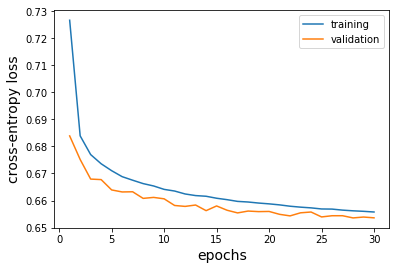

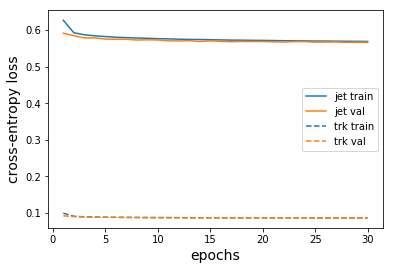

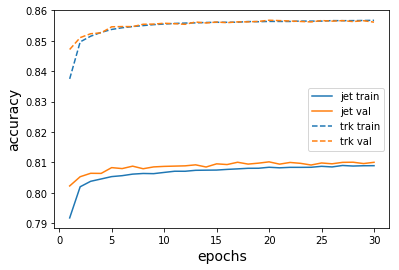

In [8]:
trainingMetrics(m.modelName)

Ok, I don't know why the history object only saved a single entry, I thought the whole model had trained... maybe needs some further investigation? 

I'm surprised why the loss is so low even if the accuracy isn't that good.

### Look at the roc curve

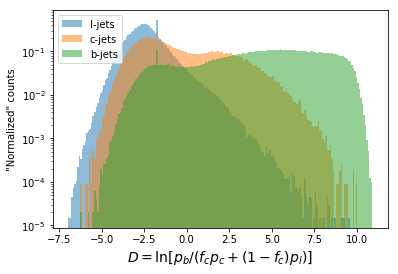

In [9]:
leffs, ceffs, beffs = [], [], []

leff, ceff, beff = sigBkgEff(m, X_te, y_te, ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [10]:
labels = ['with Vadim\'s variables']

../plottingFcts.py:429: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


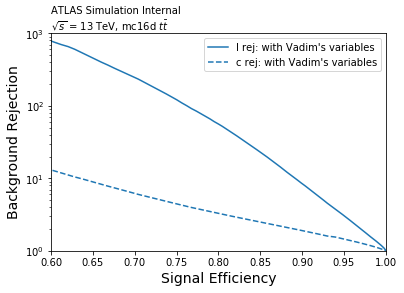

In [11]:
btagROC(beffs, leffs, ceffs, labels)

Ok, so it doesn't really look like these variables are helping to me, but I'm also not 100% sure this model has converged.

I should c.f. with the model with $\alpha = 1$ without Vadim's variables.

In [12]:
dataFile = '../data/mc16d'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X_te = f['X_test'][:]
y_te = f['y_test'][:]
y_trk_te = f['y_trk_test'][:].astype(int)
ix_te = f['ix_test'][:]

f.close()

In [13]:
_, nTrks, nFeatures = X_te.shape

Initialize method from myModel()
alpha= 1
Loading weights for previously trained model
Jet_class_acc
Jet_class_loss
Trk_class_acc
Trk_class_loss
loss
val_Jet_class_acc
val_Jet_class_loss
val_Trk_class_acc
val_Trk_class_loss
val_loss


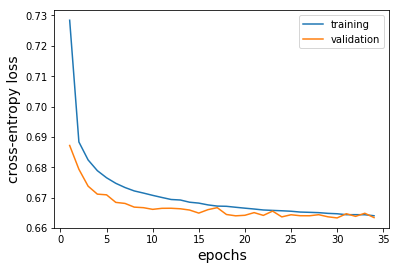

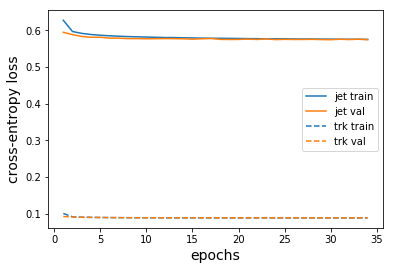

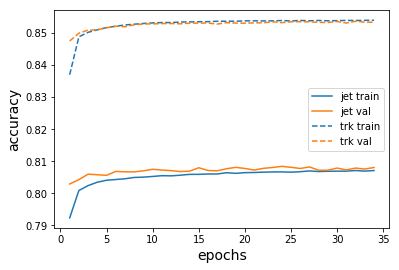

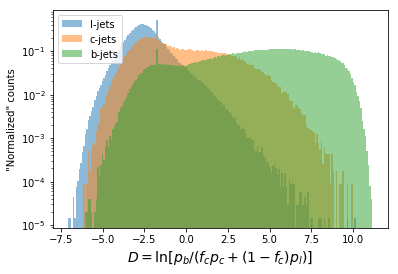

In [14]:
m2 = LSTM_trkClass(modelDir=modelDir,nFeatures=nFeatures, 
                  dataTag=dataTag, nTrkClasses=nTrkClasses,
                  alpha=1, loadModel=True)

trainingMetrics(m2.modelName)

leff, ceff, beff = sigBkgEff(m2, X_te, y_te, ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [15]:
labels = ['with Vadim\'s variables',
          'net w/o Vadim\'s variables']

../plottingFcts.py:429: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


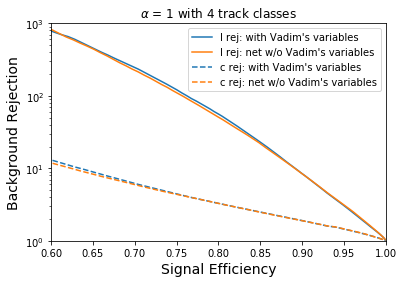

In [16]:
btagROC(beffs, leffs, ceffs, labels,
        title='$\\alpha$ = 1 with 4 track classes',
        tag='Vadim_vars')

**Conclusion:** Vadim's variables are helping (a little bit).

## Follow-up from chatting with Michael

Actually, it's unclear whether these gains are w/in our margin of error. So I should 
1. Remake these curves w/ error bars
2. Make it a ratio plot

**Binomial errors:**

For an estimate of an efficiency $\epsilon$, we need the errors to be binomial,

$$\delta \epsilon = \sqrt{\frac{\epsilon (1-\epsilon)}{N}}$$

For the error on a rejection, need to use error propagation:

$$\delta \left( \frac{1}{\epsilon} \right) = \left( \frac{1}{\epsilon} \right)^2 \delta \epsilon $$

I'm going to start off by just seeing if these errors are even visible

In [5]:
import numpy as np

In [1]:
nTest = 1.5e6

eff_err = lambda x: np.sqrt(x*(1-x)/nTest)

Ok, so I'm going to start off by just plotting the $\pm 1 \sigma$ curves for the l-rejection without the.

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


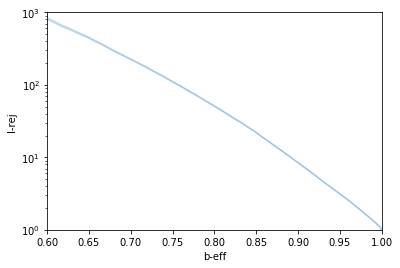

In [30]:
lrej = 1 / leff
lrej_err = np.power(lrej,2) * eff_err(leff)

lrej1 = lrej + lrej_err
lrej2 = lrej - lrej_err

plt.semilogy(beff,lrej1,'C0',alpha=0.25)
plt.semilogy(beff,lrej2,'C0',alpha=0.25)
plt.xlabel('b-eff')
plt.ylabel('l-rej')

plt.xlim(.6,1)
plt.ylim(1,1e3)

plt.show()

Maybe it would be better to use the pylab fill_between function??

In [31]:
import pylab as p

In [33]:
?p.fill_between

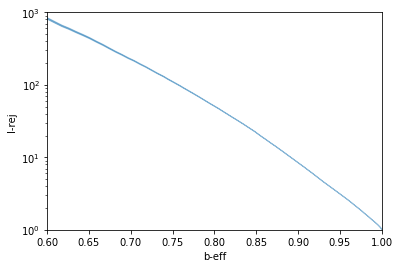

In [37]:
p.fill_between(beff,lrej2,lrej1,color='C0',alpha=0.5)
#plt.semilogy(beff,'C0',alpha=0.25)
plt.xlabel('b-eff')
plt.ylabel('l-rej')

plt.xlim(.6,1)
plt.ylim(1,1e3)
plt.yscale('log')
plt.show()

What about a ratio plot?

Need to write an new function, plotRatio was really designed for plotting discriminants.

In [41]:
len(beffs)

2

In [49]:
np.max(beffs[0]-beffs[1])

0.04450032166594478